In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'
%run 'bin/plot_utilization.py'
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
import radical.entk as re

plt.style.use('/Users/mturilli/github/radical-cybertools/radical.analytics/styles/radical_mpl.txt')
#plt.style.use('seaborn-ticks')

In [2]:
! radical-stack


  python               : /Users/mturilli/.virtualenvs/analytics/bin/python3
  pythonpath           : 
  version              : 3.8.10
  virtualenv           : /Users/mturilli/.virtualenvs/analytics

  radical.analytics    : 1.5.0-v1.5.0-80-g9b692ad@feature-utilization
  radical.entk         : 1.6.5
  radical.gtod         : 1.5.0
  radical.pilot        : 1.6.6-v1.6.6-16-g3a1f6dd97@feature-resource_separation
  radical.saga         : 1.6.6
  radical.utils        : 1.6.6



In [3]:
suds = ['re.session.login1.lei.018775.0008',
        're.session.login1.lei.018775.0007',
        're.session.login1.lei.018775.0004',
        're.session.login1.lei.018775.0005']
sdir = '../data/raw/incite2021/'
sids = [sdir+s for s in suds]

In [4]:
%%capture capt

ss = {}
for sid in suds:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot'   , inplace=False),
                    't': ss[sid]['s'].filter(etype='task'    , inplace=False),
                    'w': ss[sid]['s'].filter(etype='pipeline', inplace=False)})

In [5]:
for sid in suds:
    ss[sid].update({'sid'       : ss[sid]['s'].uid,
                    'lm'        : ss[sid]['s'].get(etype='pilot')[0].cfg['agent_launch_method'],
                    'hostid'    : ss[sid]['s'].get(etype='pilot')[0].cfg['hostid'],
                    'cores_node': ss[sid]['s'].get(etype='pilot')[0].cfg['resource_details']['rm_info']['cores_per_node'],
                    'gpus_node' : ss[sid]['s'].get(etype='pilot')[0].cfg['resource_details']['rm_info']['gpus_per_node'],
                    'smt'       : ss[sid]['s'].get(etype='pilot')[0].cfg['resource_details']['rm_info']['smt']
    })
    
    ss[sid].update({
                    'pid'       : ss[sid]['p'].list('uid'),
                    'npilot'    : len(ss[sid]['p'].get()),
                    'npact'     : len(ss[sid]['p'].timestamps(state='PMGR_ACTIVE'))
    })

    ss[sid].update({
                    'ntask'     : len(ss[sid]['t'].get()),
                    'ntdone'    : len(ss[sid]['t'].timestamps(state='DONE')),
                    'ntfailed'  : len(ss[sid]['t'].timestamps(state='FAILED')),
                    'ntcanceled': len(ss[sid]['t'].timestamps(state='CANCLED'))
    })

    
    ss[sid].update({'pres'      : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['resource'],
                    'ncores'    : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus'     : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']
    })
    
    ss[sid].update({'nnodes'    : int(ss[sid]['ncores']/ss[sid]['cores_node'])})

In [6]:
info = []
for sid in suds:
    info.append({'session'   : sid,
                 'resource'  : ss[sid]['pres'],
                 'cores_node': ss[sid]['cores_node'],
                 'gpus_node' : ss[sid]['gpus_node'],
                 'pilot_lm'  : ss[sid]['lm'], 
                 'pilots'    : ss[sid]['npilot'],
                 'ps_active' : ss[sid]['npact'],
                 'cores'     : int(ss[sid]['ncores']/ss[sid]['smt']), 
                 'gpus'      : ss[sid]['ngpus'], 
                 'nodes'     : ss[sid]['nnodes'], 
                 'tasks'     : ss[sid]['ntask'], 
                 't_done'   : ss[sid]['ntdone'],  
                 't_failed' : ss[sid]['ntfailed']})

df_info = pd.DataFrame(info) 
df_info

,session,resource,cores_node,gpus_node,pilot_lm,pilots,ps_active,cores,gpus,nodes,tasks,t_done,t_failed
0,re.session.login1.lei.018775.0008,ornl.summit,168,6,JSRUN,1,1,2688,384,64,2,2,0
1,re.session.login1.lei.018775.0007,ornl.summit,168,6,JSRUN,1,1,13440,1920,320,10,10,0
2,re.session.login1.lei.018775.0004,ornl.summit,168,6,JSRUN,1,1,26880,3840,640,20,20,0
3,re.session.login1.lei.018775.0005,ornl.summit,168,6,JSRUN,1,1,53760,7680,1280,40,40,0


In [7]:
for sid in suds:
    w  = ss[sid]['w']
    t  = ss[sid]['t']
    p  = ss[sid]['p']
    p0 = p.get(uid=ss[sid]['pid'])[0]

    ss[sid].update({
      'ttc'  : p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.NEW                }, 
                                  [{ru.EVENT: 'state'        , ru.STATE: rp.DONE               },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED             }]]),
      'ttq_p': p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE_PENDING}, 
                                   {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE        } ]),
      'ttx_w': w.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SCHEDULING  },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.DONE        } ]),
      'ttx_u': t.duration( event=[ {ru.EVENT: 'task_exec_start', ru.STATE: None                  },      
                                   {ru.EVENT: 'task_exec_stop' , ru.STATE: None                  } ]),
      'ttx_p': p0.duration(event=[ {ru.EVENT: 'state'        , ru.STATE: rp.PMGR_ACTIVE        },
                                  [{ru.EVENT: 'state'        , ru.STATE: rp.DONE               },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.FAILED             },
                                   {ru.EVENT: 'state'        , ru.STATE: rp.CANCELED           }]]),
      'sub_t': t.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SCHEDULING  },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.SUBMITTING  } ]),
      'ttx_t': t.duration( event=[ {ru.EVENT: 'state'        , ru.STATE: re.states.SUBMITTING  },
                                  [{ru.EVENT: 'state'        , ru.STATE: re.states.COMPLETED   },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.CANCELED    },
                                   {ru.EVENT: 'state'        , ru.STATE: re.states.FAILED      }]])})
    
    ss[sid].update({'ovh_rtc': ss[sid]['ttx_w'] - ss[sid]['ttx_u']})

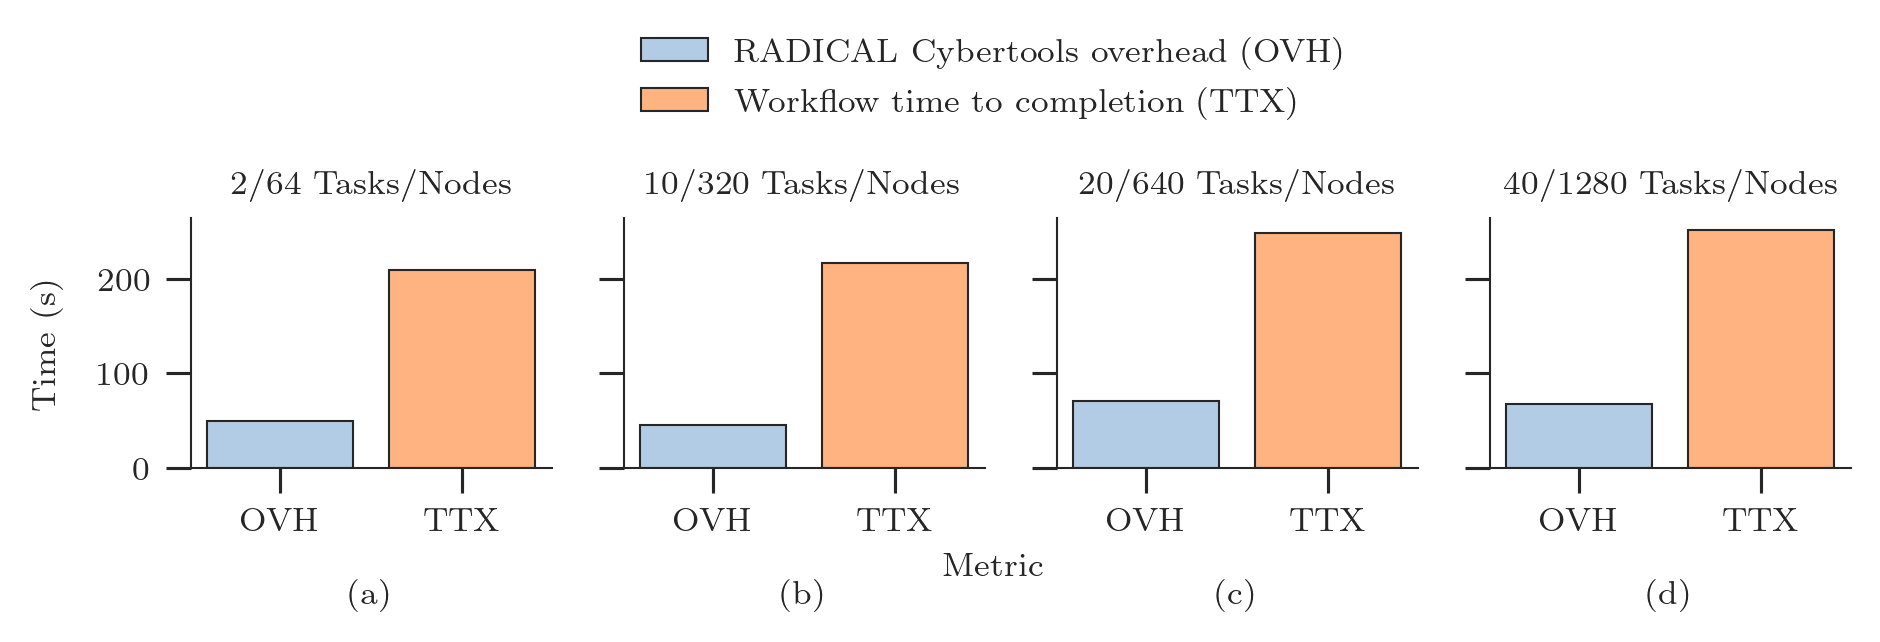

In [8]:
skip = []
nsids = len(suds) - len(skip)


fwidth, fhight = ra.get_plotsize(516,subplots=(1, nsids))
fig, axarr = plt.subplots(1, nsids, sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in suds:

    if sid in skip:
        continue

    if len(suds) > 1:
        ax = axarr[i]
    else:
        ax = axarr
    
    ax.title.set_text('%s/%s Tasks/Nodes' % (ss[sid]['ntask'], int(ss[sid]['nnodes'])))

    ax.bar(x = 'OVH', height = ss[sid]['ovh_rtc'], color = tableau20[1])
    ax.bar(x = 'TTX', height = ss[sid]['ttx_t']  , color = tableau20[3])

    ax.set_xlabel('(%s)' % j, labelpad=10)

    i = i+1
    j = chr(ord(j) + 1)

fig.text(  0.05,  0.5 , 'Time (s)', va='center', rotation='vertical')
fig.text(  0.5 , -0.2, 'Metric'  , ha='center')
fig.legend(['RADICAL Cybertools overhead (OVH)', 'Workflow time to completion (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.5, 1.5), ncol=1)
    
plt.savefig('figures/incite_2021_ovh_ttx.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/incite_2021_ovh_ttx.png', dpi=300, bbox_inches='tight')

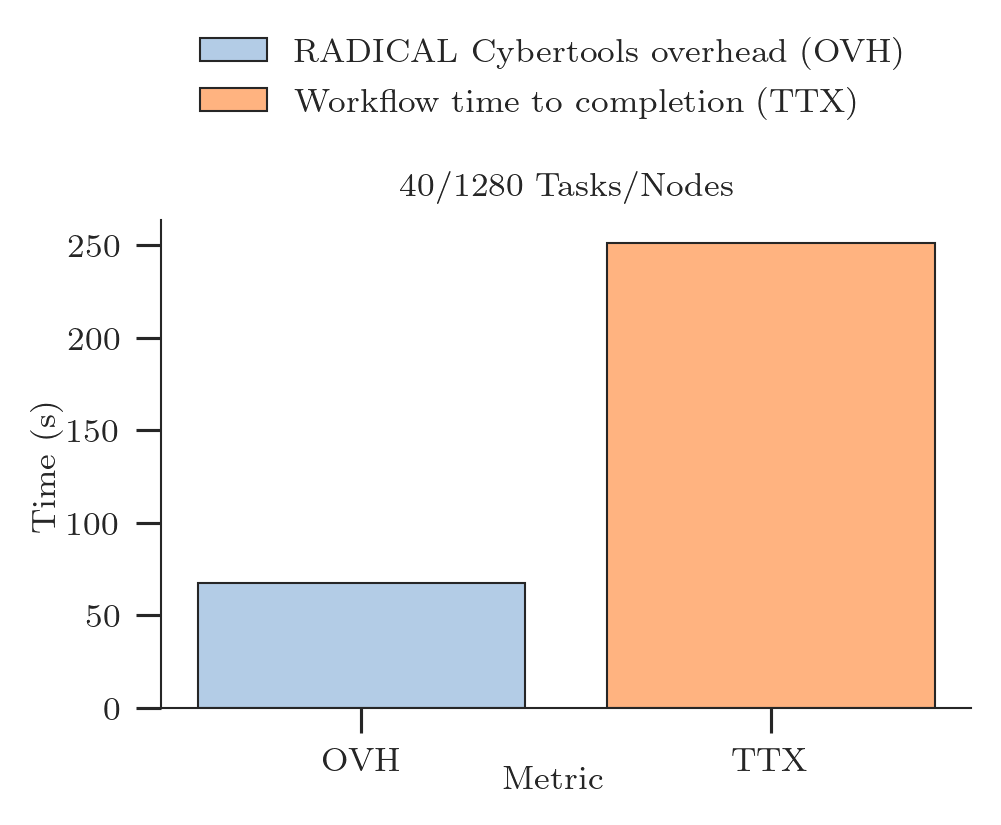

In [9]:
skip = ['re.session.login1.lei.018775.0008',
        're.session.login1.lei.018775.0007',
        're.session.login1.lei.018775.0004']
nsids = len(suds) - len(skip)


fwidth, fhight = ra.get_plotsize(252)
fig, axarr = plt.subplots(1, nsids, sharey=True, figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in suds:

    if sid in skip:
        continue

    if nsids > 1:
        ax = axarr[i]
        ax.set_xlabel('(%s)' % j, labelpad=10)
    else:
        ax = axarr
    
    ax.title.set_text('%s/%s Tasks/Nodes' % (ss[sid]['ntask'], int(ss[sid]['nnodes'])))

    ax.bar(x = 'OVH', height = ss[sid]['ovh_rtc'], color = tableau20[1])
    ax.bar(x = 'TTX', height = ss[sid]['ttx_t']  , color = tableau20[3])

    i = i+1
    j = chr(ord(j) + 1)

fig.text(  0,  0.5, 'Time (s)', va='center', rotation='vertical')
fig.text(  0.5,0, 'Metric'  , ha='center')
fig.legend(['RADICAL Cybertools overhead (OVH)', 'Workflow time to completion (TTX)'], loc='upper center', 
           bbox_to_anchor=(0.5, 1.2), ncol=1)
    
plt.savefig('figures/incite_2021_ovh_ttx.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/incite_2021_ovh_ttx.png', dpi=300, bbox_inches='tight')

In [10]:
# metrics_default = [
#         # pilot overheads (global)
#         ['Pilot Startup'    , ['boot', 'setup_1']],
#         ['Pilot Termination', ['term' ]],
#         # derived pilot durations
#         ['Agent Nodes',       ['agent']],
#         ['Warmup',            ['warm' ]],
#         ['Draining',          ['drain']],
#         ['Idle',              ['idle' ]],
#         # unit durations (PRTE)
#         ['Prepare Exec',      ['exec_queue', 'exec_prep']],
#         ['Exec RP',           ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']],
#         ['Exec Cmd',          ['exec_cmd']],
#         ['Unschedule',        ['unschedule']],
# ]

metrics = [
    ['Bootstrap', ['boot', 'setup_1']                         , '#c6dbef'],
    ['Warmup'   , ['warm' ]                                   , '#f0f0f0'],
    ['Schedule' , ['exec_queue','exec_prep', 'unschedule']    , '#c994c7'],
    ['Exec RP'  , ['exec_rp', 'exec_sh', 'term_sh', 'term_rp'], '#fdbb84'],
    ['Exec Cmd' , ['exec_cmd']                                , '#e31a1c'],
    ['Cooldown' , ['drain']                                   , '#addd8e']
]

In [11]:
%%capture capt

# Remove cache to avoid reloading errors
! rm -r ~/.radical/analytics

# Skip sessions we do not need to plot
skip = []
# keep order
sids_pruned = [sid for sid in sids if sid not in skip]

# Type of resource we want to plot: cpu or gpu
rtype='gpu'

exp = ra.Experiment(sids_pruned, stype='radical.pilot')
provided, consumed, stats_abs, stats_rel, info = exp.utilization(metrics=metrics, rtype=rtype)

In [12]:
# Use number of nodes instead of number of resources for the Y axes
def update_ticks(x, pos):
    nnodes = x/ss[sid]['cores_node']
    if rtype == 'gpu':
        nnodes = x/ss[sid]['gpus_node']
    return int(nnodes)

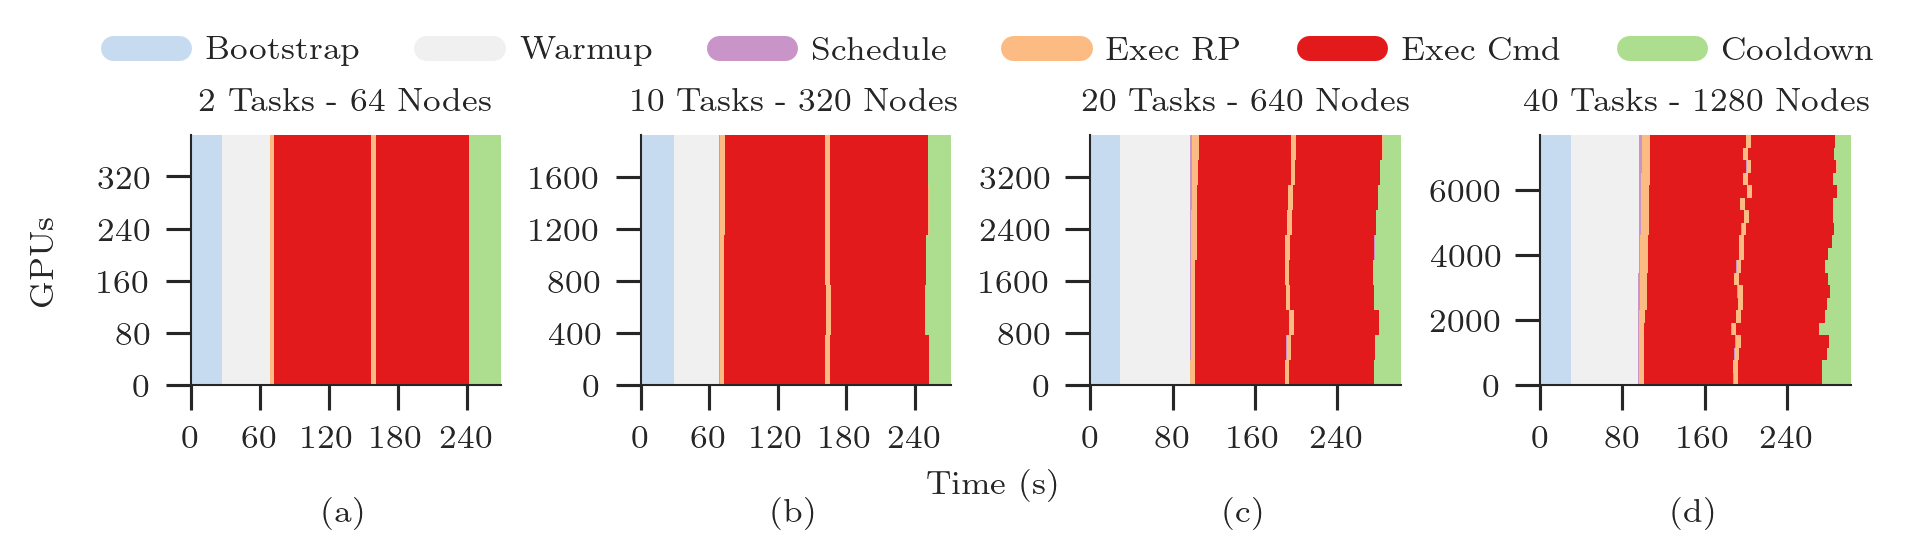

In [13]:
# sessions you want to plot
splot = [os.path.basename(s) for s in sids_pruned]
nsids = len(splot)

# Create figure and 1 subplot for each session
# Use LaTeX document page size (see RA Plotting Chapter)
fwidth, fhight = ra.get_plotsize(516, subplots=(1, nsids))
fig, axarr = plt.subplots(1, nsids, sharex='col', figsize=(fwidth, fhight))

# Avoid overlapping between Y-axes ticks and sub-figures
plt.subplots_adjust(wspace=0.45)

# Generate the subplots with labels
i = 0
j = 'a'
legend = None
for sid in splot:

    # Use a single plot if we have a single session
    if nsids > 1:
        ax = axarr[i]
        ax.set_xlabel('(%s)' % j, labelpad=10)
    else:
        ax = axarr
        
    # Get the start time of each pilot
    p_zeros = ra.get_pilots_zeros(exp)

    # Plot legend, patched, X and Y axes objects (here we know we have only 1 pilot)
    legend, patches, x, y = ra.get_plot_utilization(metrics, consumed, p_zeros, sid, ss[sid]['p'].list('uid')[0])

    # Place all the patches, one for each metric, on the axes
    for patch in patches:
        ax.add_patch(patch)

    # Title of the plot. Facultative, requires info about session (see RA Info Chapter)
    ax.set_title('%s Tasks - %s Nodes' % (ss[sid]['ntask'], int(ss[sid]['nnodes'])))
    
    # Format axes
    ax.set_xlim([x['min'], x['max']])
    ax.set_ylim([y['min'], y['max']])
    ax.yaxis.set_major_locator(MaxNLocator(5)) 
    ax.xaxis.set_major_locator(MaxNLocator(5)) 

    i = i+1
    j = chr(ord(j) + 1)
    
# Add legend
fig.legend(legend, [m[0] for m in metrics], 
           loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=6)

# Add axes labels
fig.text( 0.05,  0.5, '%ss' % rtype.upper(), va='center', rotation='vertical')
fig.text( 0.5 , -0.2, 'Time (s)', ha='center')

# Save a publication quality plot
plt.savefig('figures/incite_2021_ru.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/incite_2021_ru.png', dpi=300, bbox_inches='tight')

In [14]:
%%capture capt

# Remove cache to avoid reloading errors
! rm -r ~/.radical/analytics

# Skip sessions we do not need to plot
skip = []
# keep order
sids_pruned = [sid for sid in sids if sid not in skip]

# Type of resource we want to plot: cpu or gpu
rtypes=['cpu', 'gpu']

provided  = {}
consumed  = {}
stats_abs = {}
stats_rel = {}
info_ru   = {}
legend    = {}
patches   = {}
x         = {}
y         = {}

exp = ra.Experiment(sids_pruned, stype='radical.pilot')

for rtype in rtypes:
    provided[rtype], consumed[rtype], stats_abs[rtype], stats_rel[rtype], \
            info_ru[rtype] = exp.utilization(metrics=metrics, rtype=rtype)

# Get the start time of each pilot
p_zeros = ra.get_pilots_zeros(exp)

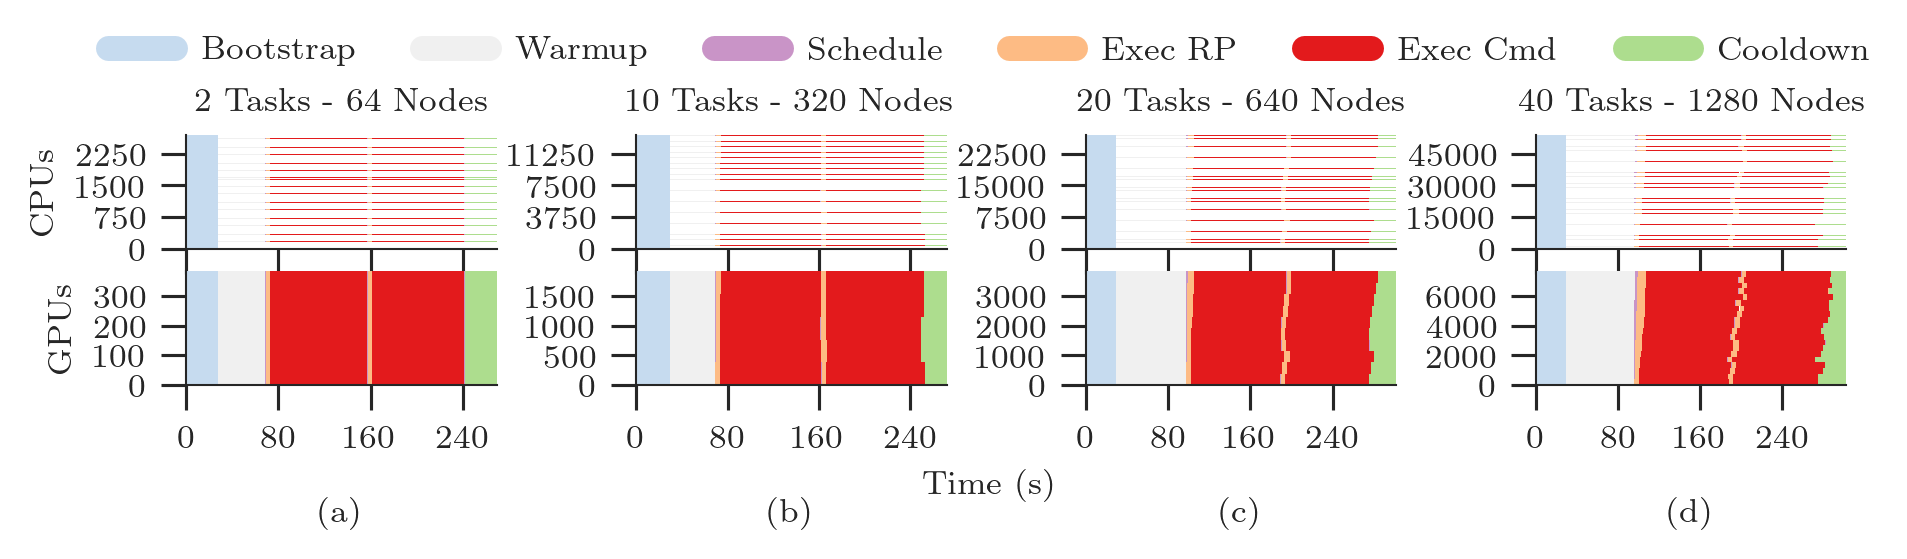

In [15]:
# sessions you want to plot
splot = [os.path.basename(s) for s in sids_pruned]
nsids = len(splot)

# Create figure and 1 subplot for each session
# Use LaTeX document page size (see RA Plotting Chapter)
fwidth, fhight = ra.get_plotsize(516, subplots=(1, nsids))
fig, axarr = plt.subplots(2, nsids, sharex='col', figsize=(fwidth, fhight))

# Avoid overlapping between Y-axes ticks and sub-figures
plt.subplots_adjust(wspace=0.45)

# Generate the subplots with labels

k = 0
for rtype in rtypes:
    
    i = 0
    j = 'a'
    for sid in splot:

        # Plot legend, patched, X and Y axes objects (here we know we have only 1 pilot)
        legend[rtype], patches[rtype], x[rtype], y[rtype] = ra.get_plot_utilization(metrics, 
                                                                                    consumed[rtype], 
                                                                                    p_zeros, 
                                                                                    sid, 
                                                                                    ss[sid]['p'].list('uid')[0])

        # Place all the patches, one for each metric, on the axes
        for patch in patches[rtype]:
            axarr[k][i].add_patch(patch)

        # Title of the plot. Facultative, requires info about session (see RA Info Chapter)
        # We set the title only on the first raw of plots
        if rtype == 'cpu':
            axarr[k][i].set_title('%s Tasks - %s Nodes' % (ss[sid]['ntask'], int(ss[sid]['nnodes'])))

        # Format axes
        axarr[k][i].set_xlim([x[rtype]['min'], x[rtype]['max']])
        axarr[k][i].set_ylim([y[rtype]['min'], int(y[rtype]['max'])])
        axarr[k][i].yaxis.set_major_locator(MaxNLocator(4)) 
        axarr[k][i].xaxis.set_major_locator(MaxNLocator(4))

        if rtype == 'cpu':
            # Specific to Summit when using SMT=4 (default)
            axarr[k][i].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: int(x/4))) 

        # Y label per subplot. We keep only the 1st for each raw.
        if i == 0:
            axarr[k][i].set_ylabel('%ss' % rtype.upper())
            
        # Set x labels to letters for references in the paper. 
        # Set them only for the bottom-most subplot
        if rtype == 'gpu':
            axarr[k][i].set_xlabel('(%s)' % j, labelpad=10)
            
        # update session id and raw identifier letter
        i = i+1
        j = chr(ord(j) + 1)
        
    # Update resource type
    k = k+1


# Add legend
fig.legend(legend[rtype], [m[0] for m in metrics], 
           loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=6)

# Add axes labels
fig.text( 0.5 , -0.2, 'Time (s)', ha='center')

# Save a publication quality plot
plt.savefig('figures/incite_2021_ru.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/incite_2021_ru.png', dpi=300, bbox_inches='tight')

cache read failed: [Errno 2] No such file or directory: '/Users/mturilli/.radical/analytics/cache//re.session.login1.lei.018775.0005.pickle'


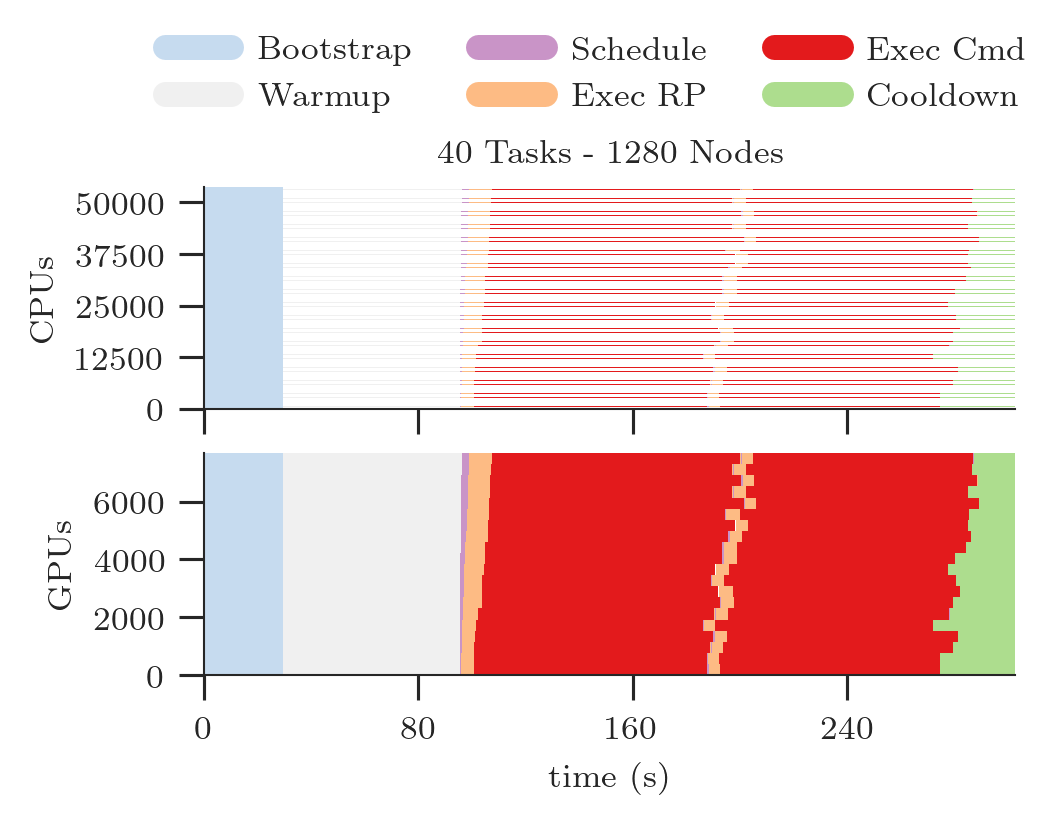

In [16]:
# %%capture capt

metrics = [
    ['Bootstrap', ['boot', 'setup_1']                         , '#c6dbef'],
    ['Warmup'   , ['warm' ]                                   , '#f0f0f0'],
    ['Schedule' , ['exec_queue','exec_prep', 'unschedule']    , '#c994c7'],
    ['Exec RP'  , ['exec_rp', 'exec_sh', 'term_sh', 'term_rp'], '#fdbb84'],
    ['Exec Cmd' , ['exec_cmd']                                , '#e31a1c'],
    ['Cooldown' , ['drain']                                   , '#addd8e']
]

# RA session, pilot and task objects
raw  = '../data/raw/incite2021/re.session.login1.lei.018775.0005'
sobj = ra.Session(raw, 'radical.pilot')
pobj = sobj.filter(etype='pilot', inplace=False)
tobj = sobj.filter(etype='task', inplace=False)
    
# Session info
sinfo = {
    'sid'       : sobj.uid,
    'lm'        : sobj.get(etype='pilot')[0].cfg['agent_launch_method'],
    'hostid'    : sobj.get(etype='pilot')[0].cfg['hostid'],
    'cores_node': sobj.get(etype='pilot')[0].cfg['resource_details']['rm_info']['cores_per_node'],
    'gpus_node' : sobj.get(etype='pilot')[0].cfg['resource_details']['rm_info']['gpus_per_node'],
    'smt'       : sobj.get(etype='pilot')[0].cfg['resource_details']['rm_info']['smt']
}

# Pilot info (assumes 1 pilot)
sinfo.update({
    'pid'       : pobj.list('uid'),
    'npilot'    : len(pobj.get()),
    'npact'     : len(pobj.timestamps(state='PMGR_ACTIVE')),
})

# Task info
sinfo.update({
    'ntask'     : len(tobj.get()),
    'ntdone'    : len(tobj.timestamps(state='DONE')),
    'ntcanceled': len(tobj.timestamps(state='CANCELED')),    
    'ntfailed'  : len(tobj.timestamps(state='FAILED')),
})

# Derive info (assume a single pilot)
sinfo.update({
    'pres'      : pobj.get(uid=sinfo['pid'])[0].description['resource'],
    'ncores'    : pobj.get(uid=sinfo['pid'])[0].description['cores'],
    'ngpus'     : pobj.get(uid=sinfo['pid'])[0].description['gpus']
})
sinfo.update({
    'nnodes'    : int(sinfo['ncores']/sinfo['cores_node'])
})

# Remove cache to avoid reloading errors
! rm -r ~/.radical/analytics

# Type of resource we want to plot: cpu or gpu
rtypes=['cpu', 'gpu']

# Experiment to plot
exp = ra.Experiment([raw], stype='radical.pilot')

# LaTeX document column size (see RA Plotting Chapter)
csize = 252
fig, axarr = plt.subplots(2, 1, figsize=(ra.get_plotsize(csize)))

# Get the start time of each pilot
p_zeros = ra.get_pilots_zeros(exp)

consumed  = {}
legend    = {}
patches   = {}
x         = {}
y         = {}
i         = 0

for rtype in rtypes:
    
    # Resource resource provided and consumed: CPU and GPU
    _ , consumed[rtype], _, _, _ = exp.utilization(metrics=metrics, rtype=rtype)

    # Plot legend, patched, X and Y axes objects (here we know we have only 1 pilot)
    legend[rtype], patches[rtype], x[rtype], y[rtype] = ra.get_plot_utilization(metrics, consumed[rtype], p_zeros, sinfo['sid'], sinfo['pid'][0])

    # Place all the CPU and GPU patches, one for each metric, on the respective axes
    for patch in patches[rtype]:
        axarr[i].add_patch(patch)

    # Format axes
    axarr[i].set_xlim([x[rtype]['min'], x[rtype]['max']])
    axarr[i].set_ylim([y[rtype]['min'], int(y[rtype]['max'])])
    axarr[i].yaxis.set_major_locator(MaxNLocator(5)) 
    axarr[i].xaxis.set_major_locator(MaxNLocator(5))

    if rtype == 'cpu':
        # Specific to Summit when using SMT=4 (default)
        axarr[i].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: int(x/4))) 
        
    # Resource-type dependend labels
    axarr[i].set_ylabel('%ss' % rtype.upper())
    axarr[i].set_xlabel('time (s)')
    
    i = i+1

# Do not repeat the X-axes label in the topmost plot
for ax in fig.get_axes():
        ax.label_outer()

# Title of the plot. Facultative, requires info about session (see RA Info Chapter)
axarr[0].set_title('%s Tasks - %s Nodes' % (sinfo['ntask'], int(sinfo['nnodes'])))

# Add legend for both plots
fig.legend(legend[rtype], [m[0] for m in metrics], 
           loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

# Save a publication quality plot
plt.savefig('figures/incite_2021_ru_single.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/incite_2021_ru_single.png', dpi=300, bbox_inches='tight')

In [17]:
# pick and choose what resources to plot (one sub-plot per resource)
resrc = ['cpu', 'gpu']

# pick and choose what contributions to plot
metrics  = [  #   metric,      line color, alpha, fill color, alpha
                ['bootstrap'  , ['#c6dbef',  0.0,   '#c6dbef',  1  ]],    
              # ['boot'       , ['#99e6e6',  0.0,   '#99e6e6',  1  ]],
              # ['setup'      , ['#1a80b2',  0.0,   '#1a80b2',  1  ]],
              # ['agent'      , ['#00AAAA',  0.0,   '#00AAAA',  0.3]],
                ['exec_cmd'   , ['#e31a1c',  0.0,   '#e31a1c',  1  ]],
                ['schedule'   , ['#c994c7',  0.0,   '#c994c7',  1  ]],
                ['exec_rp'    , ['#fdbb84',  0.0,   '#fdbb84',  1  ]],
                ['term'       , ['#addd8e',  0.0,   '#addd8e',  1  ]],
                ['idle'       , ['#f0f0f0',  0.0,   '#f0f0f0',  1  ]]
]

# ------------------------------------------------------------------------------
# transition events for pilot, task, master, worker, request
#
# event  : resource transitions from : resource transitions to
#
p_trans = [
           [{1: 'bootstrap_0_start'}     , 'system'     , 'bootstrap'  ],
           [{5: 'PMGR_ACTIVE'}           , 'bootstrap'  , 'idle'       ],
         # [{1: 'bootstrap_0_start'}     , 'system'     , 'boot'       ],
         # [{1: 'bootstrap_0_ok'}        , 'boot'       , 'setup'      ],
         # [{5: 'PMGR_ACTIVE'}           , 'setup'      , 'idle'       ],
           [{1: 'cmd', 6: 'cancel_pilot'}, 'idle'       , 'term'       ],
           [{1: 'bootstrap_0_stop'}      , 'term'       , 'system'     ],
           [{1: 'sub_agent_start'}       , 'idle'       ,'agent'       ],
           [{1: 'sub_agent_stop'}        , 'agent'      , 'term'       ]
          ]

t_trans = [
           [{1: 'schedule_ok'}           , 'idle'       , 'schedule'   ],
           [{1: 'exec_start'}            , 'schedule'   , 'exec_rp'    ],
           [{1: 'task_exec_start'}       , 'exec_rp'    , 'exec_cmd'   ],
           [{1: 'unschedule_stop'}       , 'exec_cmd'   , 'idle'       ]
          ]

m_trans = [
           [{1: 'schedule_ok'}           , 'idle'       , 'schedule'   ],
           [{1: 'exec_start'}            , 'schedule'   , 'exec_rp'    ],
           [{1: 'task_exec_start'}       , 'exec_rp'    , 'exec_master'],
           [{1: 'unschedule_stop'}       , 'exec_master', 'idle'       ]
          ]

w_trans = [
           [{1: 'schedule_ok'}           , 'idle'       , 'schedule'   ],
           [{1: 'exec_start'}            , 'schedule'   , 'exec_rp'    ],
           [{1: 'task_exec_start'}       , 'exec_rp'    , 'exec_worker'],
           [{1: 'unschedule_stop'}       , 'exec_worker', 'idle'       ]
          ]

r_trans = [
             [{1: 'req_start'}             , 'exec_worker', 'workload'   ],
             [{1: 'req_stop'}              , 'workload'   , 'exec_worker']
          ]

# what entity maps to what transition table
tmap = {
           'pilot'  : p_trans,
           'task'   : t_trans,
           'master' : m_trans,
           'worker' : w_trans,
           'request': r_trans,
       }

In [18]:
%%capture capt

import functools

# Read the session profiles
sid     = '../data/raw/incite2021/re.session.login1.lei.018775.0005'
sname   = os.path.basename(sid)
session = ra.Session.create(src=sid, stype='radical.pilot')
pilots  = session.filter(etype='pilot', inplace=False)

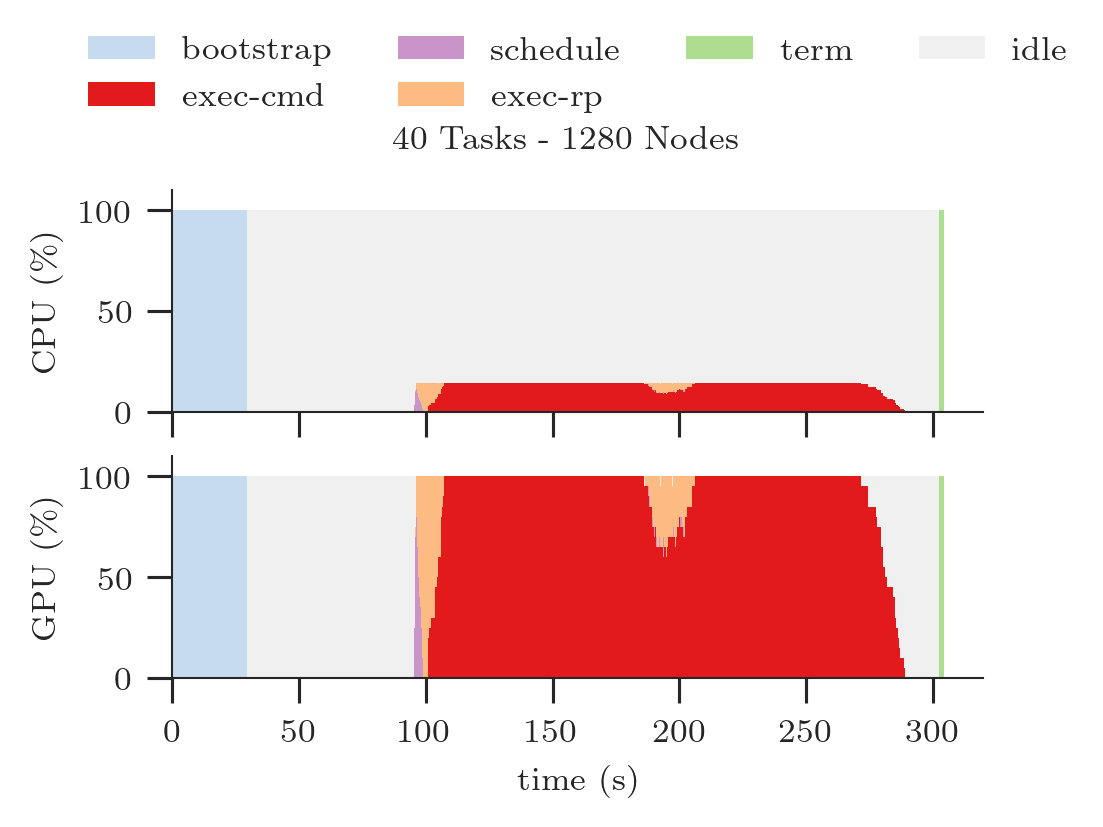

In [19]:
# metrics to stack and to plot
to_stack = [m[0] for m in metrics]
to_plot  = {m[0]: m[1] for m in metrics}

# Use to set Y-axes to % of resource utilization
use_percent = True

# one plot per pilot
for pilot in pilots.get():
    
    # Derive pilot and task timeseries of a session for each metric
    p_resrc, series, x = ra.get_pilot_series(session, pilot, tmap, resrc, use_percent)

    # #plots = # of resource types (e.g., CPU/GPU = 2 resource types = 2 plots)
    n_plots = 0
    for r in p_resrc:
        if p_resrc[r]:
            n_plots += 1

    # sub-plots for each resource type, legend on first, x-axis shared
    fig = plt.figure(figsize=(ra.get_plotsize(252)))
    gs  = mpl.gridspec.GridSpec(n_plots, 1)

    for plot_id, r in enumerate(resrc):

        if not p_resrc[r]:
            continue

        # create sub-plot
        ax = plt.subplot(gs[plot_id])
        
        # stack timeseries for each metrics into areas
        areas = ra.stack_transitions(series, r, to_stack)
        
        # plot individual metrics
        prev_m  = None
        lines   = list()
        patches = list()
        legend  = list()
        for num, m in enumerate(areas.keys()):

            if m not in to_plot:
                if m != 'time':
                    print('skip', m)
                continue

            lcol   = to_plot[m][0]
            lalpha = to_plot[m][1]
            pcol   = to_plot[m][2]
            palpha = to_plot[m][3]

            # plot the (stacked) areas
            line, = ax.step(areas['time'], areas[m], where='post', label=m,
                            color=lcol, alpha=lalpha, linewidth=1.0)

            # fill first metric toward 0, all others towards previous line
            if not prev_m:
                patch = ax.fill_between(areas['time'], areas[m],
                                        step='post', label=m, linewidth=0.0,
                                        color=pcol, alpha=palpha)

            else:
                patch = ax.fill_between(areas['time'], areas[m], areas[prev_m], 
                                        step='post', label=m, linewidth=0.0,
                                        color=pcol, alpha=palpha)

            # remember lines and patches for legend
            legend.append(m.replace('_', '-'))
            patches.append(patch)

            # remember this line to fill against
            prev_m = m

        ax.set_xlim([x['min'], x['max']])
        if use_percent:
            ax.set_ylim([0, 110])
        else:
            ax.set_ylim([0, p_resrc[r]])

        ax.set_xlabel('time (s)')
        ax.set_ylabel('%s (%s)' % (r.upper(), '\%'))
        

        # first sub-plot gets legend
        if plot_id == 0:
            ax.legend(patches, legend, loc='upper center', ncol=4,
                      bbox_to_anchor=(0.5, 1.8), fancybox=True, shadow=True)
            
    for ax in fig.get_axes():
        ax.label_outer()

    # Title of the plot
    if ss[sname]['npilot'] == 1:
        fig.suptitle('%s Tasks - %s Nodes' % (ss[sname]['ntask'], ss[sname]['nnodes']))
    else:
        fig.suptitle('%s: %s Tasks - %s Nodes' % (pilot.uid, ss[sname]['ntask'], int(ss[sname]['nnodes'])))    
    
    # Save a publication quality plot
    fname = '%s_%s_incite_2021_ru_area' % (sname, pilot.uid)
    fig.savefig('figures/%s.pdf' % fname, dpi=300, bbox_inches='tight')
    fig.savefig('figures/%s.png' % fname, dpi=300, bbox_inches='tight')